# Fitting Univariate Distributions

*Purpose*: 


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

In [2]:
from grama.data import df_shewhart


# Fitting Distributions


## Check for *statistical control*

TODO


*Note*: To help with the next task, it will be helpful to know about the *integer division* operator `//`. This divides by a desired value, but rounds down to the nearest integer.


In [23]:
print("1 // 4 = {}".format(1 // 4))
print("2 // 4 = {}".format(2 // 4))
print("3 // 4 = {}".format(3 // 4))
print("4 // 4 = {}".format(4 // 4))
print("5 // 4 = {}".format(5 // 4))

1 // 4 = 0
2 // 4 = 0
3 // 4 = 0
4 // 4 = 1
5 // 4 = 1


### __qX__ Add a group identifier

Create a group identifier column `id_group` that assigns observations to consecutive groups of four. Make sure the first group identifier is `0`, and use sequential integers.


In [24]:
## TODO: Create a group identifier column to make
# batches of 4 consecutive values
n_grp = 4

df_rolling = (
    df_shewhart
# task-begin
    ## TASK: Create a group identifier called id_group
# task-end
# solution-begin
    >> gr.tf_mutate(id_group=DF.index // n_grp)
# solution-end
)

## NOTE: Don't edit the following; use this to check your work
assert \
    "id_group" in df_rolling.columns, \
    "df_rolling missing the id_group column"

assert \
    all(df_rolling.id_group[:8] == [0]*4 + [1]*4), \
    "The id_group column is incorrect; " + \
    "the first 8 values should be 0, 0, 0, 0, 1, 1, 1, 1"


### __qX__ Compute the batch means

Compute the mean within each consecutive "batch" of observations.


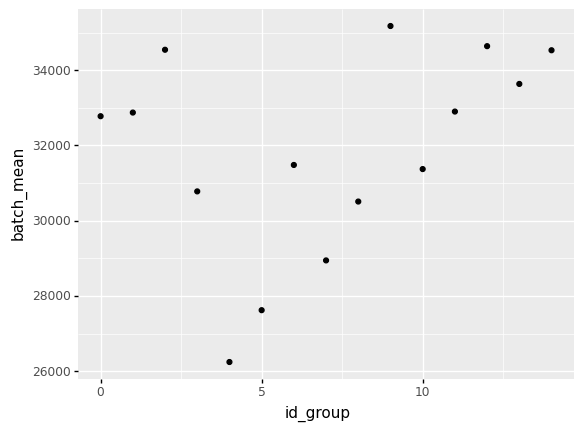

<ggplot: (8782979192778)>

In [34]:
## TASK: Compute the `batch_mean` within 
# each group of observations
df_batches = (
    df_rolling
# task-begin
    # TODO: Compute the `batch_mean`
# task-end
# solution-begin
    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(
        batch_mean=gr.mean(DF.tensile_strength)
    )
# solution-end
)

## NOTE: Don't edit the following; use this to check your work
assert \
    df_batches.shape[0] == (df_shewhart.shape[0] / n_grp), \
    "Size of df_batches is incorrect; " + \
    "make sure you grouped properly."

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_point()
)

### Control limits

Remember from the Monte Carlo exercise that a confidence interval for the mean can be approximated using the central limit theorem via

$$[\hat{\mu} - q \hat{\sigma} / \sqrt{n}, \hat{\mu} + q \hat{\sigma} / \sqrt{n}],$$

where $\hat{\mu}$ is the sample mean, $\hat{\sigma}$ is the sample standard deviation, and $n$ is the number of samples used to compute $\hat{\mu}$.


In [38]:
# NOTE: No need to edit; this computes the probability of
# finding a batch mean outside the control limits
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
mg_norm.p(-3) * 2


0.0026997960632601866

In [9]:
# NOTE: No need to edit
df_stats = (
    df_shewhart
    >> gr.tf_summarize(
        tys_mean=gr.mean(DF.tensile_strength),
        tys_sd=gr.sd(DF.tensile_strength),
        n=gr.n(DF.tensile_strength),
    )
)
df_stats


,tys_mean,tys_sd,n
0,31869.366667,3996.380795,60


### __qX__ Compute the control limits

Compute the control limits for the batch means. Use a multiplier of $q = 3$. Answer the questions under *observations* below.


0    37863.937859
Name: tys_hi, dtype: float64


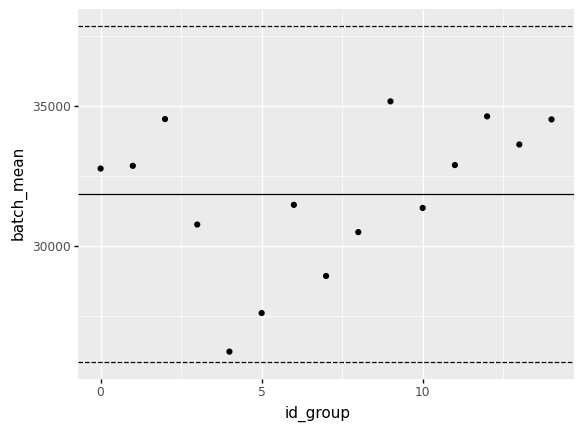

<ggplot: (8782950458043)>

In [39]:
df_limits = (
    df_stats
# solution-begin
    >> gr.tf_mutate(
        tys_lo=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_grp),
        tys_hi=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_grp),
    )
# solution-end
)

## NOTE: Don't edit the following; use this to check your work
print(df_limits.tys_hi)
assert \
    all(abs(df_limits.tys_lo - 25874.795475) < 1e-2), \
    "Lower control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"
assert \
    all(abs(df_limits.tys_hi - 37863.937859) < 1e-2), \
    "Upper control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_lo"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_hi"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

*Observations*

<!-- task-begin -->
- Do any batch means fall outside the control limits?
  - (Your response here)
- 
<!-- task-end -->

As with adjusting the bin size of a histogram, it is also important to test different batch sizes with a control chart. The following re-constructs the control chart, but with a slightly smaller batch size:


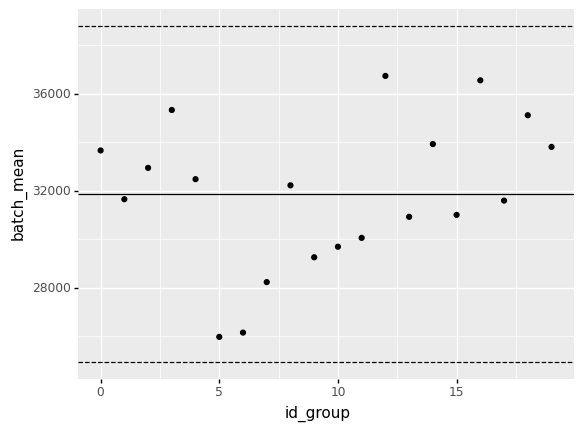

<ggplot: (8782954511023)>

In [48]:
# NOTE: No need to edit this
n_temp = 3

(
    df_shewhart
    >> gr.tf_mutate(id_group=DF.index // n_temp)
    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(batch_mean=gr.mean(DF.tensile_strength))
    
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_stats,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

Here we see reasonably similar behavior with no violations of the control limits and no suspicious patterns. The data from this process appear to be under statistical control. Thus, we can proceed with modeling the `tensile_strengh` as a random quantity.


## Select candidate distributions


### (Short) list of distributions

| Distribution | Name | Description |
|---|---|---|
| Normal (Gaussian) | `"norm"` | Symmetric; infinite extent |
| Lognormal | `"lognormal"` | Asymmetric; positive |
| Uniform | `"uniform"` | Bounded, flat |
| Beta | `"beta"` | Bounded, flexible shape |
| Weibull | `"weibull_min"` | Asymmetric; positive |


### __qX__ Select reasonable distributions


## Fit and assess


### QQ plots


### __qX__ Inspect this QQ plot

TODO


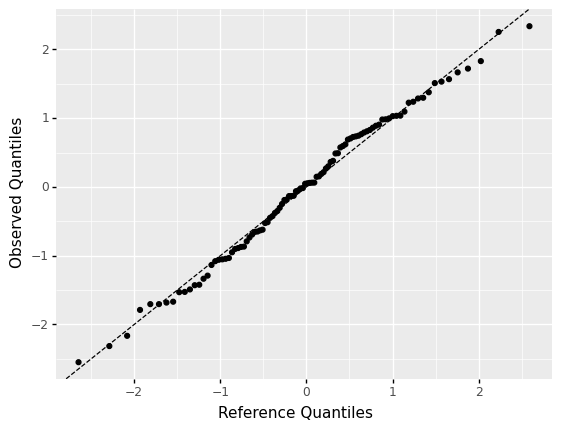

<ggplot: (8782955333464)>

In [53]:
## NOTE: No need to edit; run and inspect
# Define a standard normal distribution
mg_norm = gr.marg_mom("norm", mean=0, sd=1)

(
    # Draw some random values
    gr.df_make(z=mg_norm.r(100))
    # Compute theoretical quantiles based on fitted normal
    >> gr.tf_mutate(q=gr.qqvals(DF.z, "norm"))
    
    # Visualize
    >> gr.ggplot(gr.aes("q", "z"))
    # Add a guideline
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*

<!-- task-begin -->
- 
<!-- task-end -->

### __qX__ Fit a distribution for the `tensile_strength`

TODO


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


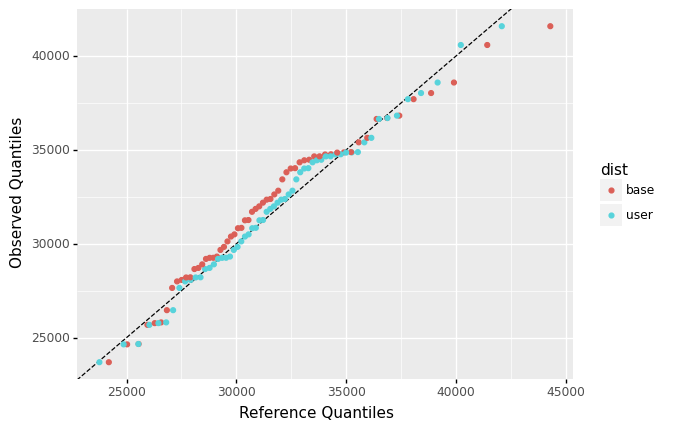

<ggplot: (8782956062717)>

In [58]:
# TASK: Fit a distribution for the tensile_strength;
# assign it to mg_user below
# task-begin
mg_user = None
# task-end
# solution-begin
mg_user = gr.marg_fit(
    "lognorm", 
    df_shewhart.tensile_strength,
    floc=0,
)
# solution-end

# NOTE: Don't edit this; use to check your results
mg_base = gr.marg_fit(
    "gengamma",
    df_shewhart.tensile_strength,
    floc=0,
)

(
    df_shewhart
    >> gr.tf_mutate(
        q_base=gr.qqvals(DF.tensile_strength, marg=mg_base),
        q_user=gr.qqvals(DF.tensile_strength, marg=mg_user),
    )
    >> gr.tf_pivot_longer(
        columns=["q_base", "q_user"],
        names_to=[".value", "dist"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "tensile_strength", color="dist"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

## Use the model

TODO
